<a href="https://colab.research.google.com/github/bhuvnk/EVA6/blob/main/Session%205%20Coding%20Drill%20Down%20/%20Model_Training_Drill_Down_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Target

- Trim the parameters below 8000
- Dropout=0.069 after each layer to avoid all overfitting
- no augmentation
- OneCycleLR from get go; because it works!!

### 2. Result

- Params: `7_864`
- Best Train Accuracy: `98.03%`
- Best Test Accuracy : `99.37%`

### 3. Analysis

- No overfitting
- Now time to add some data augmentations

## Model

## BaseLine Model

- Convolution Block 1
    - `Conv2D:  1, 14, 3; pad = 1; Out: 28x28x16`
    - `Conv2D: 14, 28, 3; pad = 1; Out: 28x28x32`
- Transition Block
    - `Conv2D: 28,  8, 1; Out: 24x24x8`
    - `MaxPool2D: 2x2;    Out: 12x12x8`
- Convolution Block 2
    - `Conv2D:  8,  12, 3; Out: 10x10x8`
    - `Conv2D: 12, 12, 3; Out: 8x8x16`
    - `Conv2D: 12, 16, 3; Out: 6x6x16`
    - `Conv2D: 16, 16, 3; Out: 4x4x16`
- Output GAP
    - `AdaptiveAvgPool2d: -;  Out: 1x1x14`
    - `Conv2D:  -, 10, 1; Out: 1x1x10`

In [1]:
!nvidia-smi

Fri Jun  4 21:30:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
drop_value = 0.069
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # dims : [28,28,1];
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding = 1, bias=False), # 28
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(drop_value),
            # RF - 3x3

            nn.Conv2d(8, 16, 3, padding = 1, bias=False), # 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(drop_value),
            # RF - 5x5
        )

        # dims : [28x28x32]
        # Bottle neck - Transition layer

        self.trans1 = nn.Sequential(
            nn.Conv2d(16, 8, 1, bias=False), # 28
            nn.ReLU(),
            # RF - 7x7

            nn.MaxPool2d(2, 2), # 14
            # RF - 14x14
        )

        # dims : [14x14x8]
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 12, 3, bias=False), # 12
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(drop_value),
            # RF - 16x16

            nn.Conv2d(12, 12, 3, bias=False), # 10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(drop_value),
            # RF - 18x18

            nn.Conv2d(12, 16, 3, bias=False), # 8
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(drop_value),
            # RF - 20x20

            nn.Conv2d(16, 16, 3, bias=False), # 4
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(drop_value),
            # RF - 22x22
        )

        # dims : 4x4x32

        # GAP Layer
        self.out = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),       # 
            nn.Conv2d(16, 10, 1, bias=False), # 6
            # RF - 20x20
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.out(x)

        x = x.view(-1, 10)
        return F.log_softmax(x)

## parameters

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             128
             ReLU-10            [-1, 8, 28, 28]               0
        MaxPool2d-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 12, 12]             864
             ReLU-13           [-1, 12, 12, 12]               0
      BatchNorm2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # init by setting the gradients to zero
        optimizer.zero_grad()

        #Predict
        output = model(data)

        #Loss Calculation
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        
        # BackProp
        loss.backward()
        optimizer.step()

        # lr changes
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training

In [7]:
N_EPOCH = 15
BASE_LR = 0.001
MAX_LR = 0.15
STEP_UP = int(N_EPOCH/5)

from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR,
                                                steps_per_epoch=len(train_loader),
                                                epochs=N_EPOCH)



for epoch in range(1, N_EPOCH+1):
    print('\nEpoch {} and Learning Rate {}: '.format(epoch, scheduler.get_last_lr()))
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1 and Learning Rate [0.006000000000000005]: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.17542307078838348 batch_id=468 Accuracy=84.42: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9743/10000 (97.43%)


Epoch 2 and Learning Rate [0.0228601195551989]: 


loss=0.06098751351237297 batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:11<00:00, 42.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9815/10000 (98.15%)


Epoch 3 and Learning Rate [0.06554426623702893]: 


loss=0.10379647463560104 batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:11<00:00, 42.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9802/10000 (98.02%)


Epoch 4 and Learning Rate [0.11406188959639837]: 


loss=0.13021399080753326 batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:11<00:00, 41.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9906/10000 (99.06%)


Epoch 5 and Learning Rate [0.14569040823405507]: 


loss=0.10168397426605225 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)


Epoch 6 and Learning Rate [0.1491551691239221]: 


loss=0.052627500146627426 batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:11<00:00, 41.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9894/10000 (98.94%)


Epoch 7 and Learning Rate [0.14255192137417153]: 


loss=0.0508260540664196 batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:11<00:00, 41.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9932/10000 (99.32%)


Epoch 8 and Learning Rate [0.12994641561991813]: 


loss=0.048379670828580856 batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:11<00:00, 42.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9909/10000 (99.09%)


Epoch 9 and Learning Rate [0.1124587063657782]: 


loss=0.04005671292543411 batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 41.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)


Epoch 10 and Learning Rate [0.09164265332253009]: 


loss=0.03393154218792915 batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:11<00:00, 41.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)


Epoch 11 and Learning Rate [0.06934785415281057]: 


loss=0.02983286790549755 batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:11<00:00, 41.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)


Epoch 12 and Learning Rate [0.04755529960196385]: 


loss=0.03705906867980957 batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:11<00:00, 41.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9921/10000 (99.21%)


Epoch 13 and Learning Rate [0.028201353776883133]: 


loss=0.04784274473786354 batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)


Epoch 14 and Learning Rate [0.013005699697519156]: 


loss=0.049646005034446716 batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9929/10000 (99.29%)


Epoch 15 and Learning Rate [0.0033185379138529515]: 


loss=0.024728812277317047 batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 41.42it/s]



Test set: Average loss: 0.0190, Accuracy: 9933/10000 (99.33%)



## Logs

Text(0.5, 1.0, 'Test Accuracy')

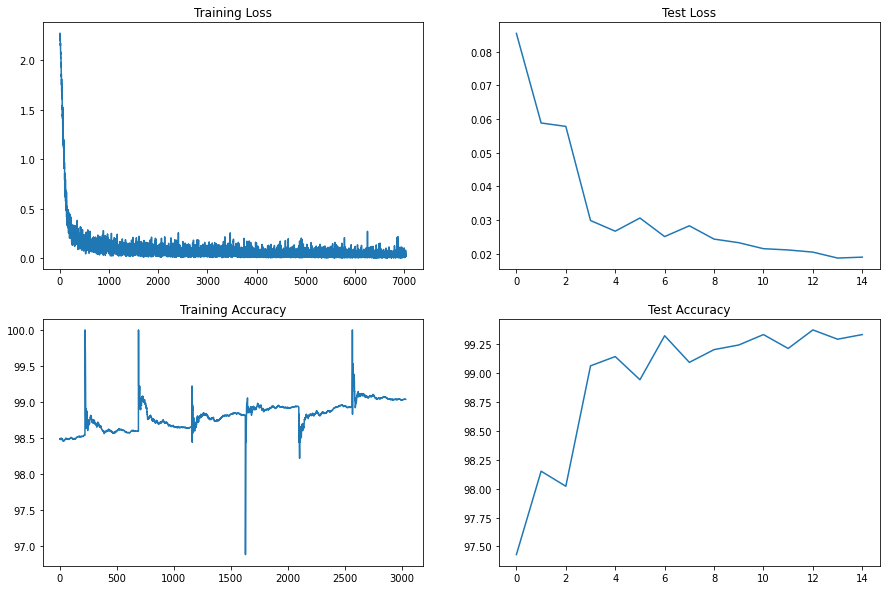

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")